In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import math 
import tensorflow as tf
import pandas_ta as ta
import pandas_datareader as web 
import matplotlib.pyplot as plt  

In [6]:
# Download stock data
# -----------------------------------------------

stock_ticker = yf.Ticker("AAPL")
stock_data = stock_ticker.history(period="max")
# Convert the index to a datetime object
stock_data.index = pd.to_datetime(stock_data.index)

# Format the datetime index to "YYYY-MM-DD"
stock_data.index = stock_data.index.strftime('%Y-%m-%d')

# convert to lowercase comlumn name 
stock_data.columns = [c.lower() for c in stock_data.columns]

# Convert  indexes to datetime just to be sure
stock_data.index = pd.to_datetime(stock_data.index)

del stock_data["dividends"]
del stock_data["stock splits"]
del stock_data["volume"]

In [7]:
# Filter data for dates from 2019 onwards
stock_data_filtered = stock_data[stock_data.index.year >= 2019]

stock_data_filtered

,open,high,low,close
Date,,,,
2019-01-02,37.025769,37.972391,36.867998,37.750076
2019-01-03,34.417793,34.833733,33.944483,33.989902
2019-01-04,34.549260,35.510224,34.374758,35.440899
2019-01-07,35.546085,35.577162,34.876756,35.362019
2019-01-08,35.751660,36.291906,35.503055,36.036125
...,...,...,...,...
2024-08-07,206.660786,213.392999,206.151381,209.577423
2024-08-08,212.863619,213.952355,208.588569,213.063385
2024-08-09,211.854792,216.529374,211.724938,215.990005


In [8]:
# Feature Engineering
# ---------------------------------

# Adding indicators to the stock data

# Example: Calculate 10-day and 50-day SMAs
stock_data_filtered['SMA_10'] = stock_data_filtered['close'].rolling(window=10).mean()
stock_data_filtered['SMA_50'] = stock_data_filtered['close'].rolling(window=50).mean()

# Example: Calculate 10-day and 50-day EMAs
stock_data_filtered['EMA_10'] = stock_data_filtered['close'].ewm(span=10, adjust=False).mean()
stock_data_filtered['EMA_50'] = stock_data_filtered['close'].ewm(span=50, adjust=False).mean()

# Calculate 14-day RSI using pandas_ta
stock_data_filtered['RSI_14'] = ta.rsi(stock_data_filtered['close'], length=14)

stock_data_filtered = stock_data_filtered.dropna()


C:\Users\Acer\AppData\Local\Temp\ipykernel_15412\1771822033.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_filtered['SMA_10'] = stock_data_filtered['close'].rolling(window=10).mean()
C:\Users\Acer\AppData\Local\Temp\ipykernel_15412\1771822033.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_filtered['SMA_50'] = stock_data_filtered['close'].rolling(window=50).mean()
C:\Users\Acer\AppData\Local\Temp\ipykernel_15412\1771822033.py:11: SettingWithCopyWarning: 
A value is trying to b

In [9]:
stock_data_filtered

,open,high,low,close,SMA_10,SMA_50,EMA_10,EMA_50,RSI_14
Date,,,,,,,,,
2019-03-14,44.149046,44.197063,43.827352,44.108234,42.529270,39.632643,42.745326,40.479821,75.107724
2019-03-15,44.377100,44.972475,44.110622,44.681988,42.796949,39.771281,43.097446,40.644612,77.641996
2019-03-18,44.605161,45.226944,44.602758,45.138119,43.089114,39.994245,43.468477,40.820828,79.434563
2019-03-19,45.217361,45.371006,44.633986,44.780430,43.353195,40.181036,43.707014,40.976106,74.397240
2019-03-20,44.708388,45.491021,44.348281,45.171726,43.680651,40.377230,43.973326,41.140640,76.177039
...,...,...,...,...,...,...,...,...,...
2024-08-07,206.660786,213.392999,206.151381,209.577423,215.661377,213.523448,215.031755,211.991406,40.192311
2024-08-08,212.863619,213.952355,208.588569,213.063385,215.243860,213.989309,214.673869,212.033445,45.237936
2024-08-09,211.854792,216.529374,211.724938,215.990005,215.072060,214.507709,214.913167,212.188604,49.118928


In [13]:
# objective now to predict price up or down
# add new comlumn tommorow based on closing price 
stock_data_filtered["tomorrow"] = stock_data_filtered["close"].shift(-1)

# convet to 1 or 0 
stock_data_filtered["target"] = (stock_data_filtered["tomorrow"] > stock_data_filtered["close"]).astype(int)

stock_data_filtered = stock_data_filtered.dropna()


C:\Users\Acer\AppData\Local\Temp\ipykernel_15412\1962636339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_filtered["tomorrow"] = stock_data_filtered["close"].shift(-1)
C:\Users\Acer\AppData\Local\Temp\ipykernel_15412\1962636339.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_filtered["target"] = (stock_data_filtered["tomorrow"] > stock_data_filtered["close"]).astype(int)


In [14]:
stock_data_filtered

,open,high,low,close,SMA_10,SMA_50,EMA_10,EMA_50,RSI_14,tomorrow,target
Date,,,,,,,,,,,
2019-03-14,44.149046,44.197063,43.827352,44.108234,42.529270,39.632643,42.745326,40.479821,75.107724,44.681988,1
2019-03-15,44.377100,44.972475,44.110622,44.681988,42.796949,39.771281,43.097446,40.644612,77.641996,45.138119,1
2019-03-18,44.605161,45.226944,44.602758,45.138119,43.089114,39.994245,43.468477,40.820828,79.434563,44.780430,0
2019-03-19,45.217361,45.371006,44.633986,44.780430,43.353195,40.181036,43.707014,40.976106,74.397240,45.171726,1
2019-03-20,44.708388,45.491021,44.348281,45.171726,43.680651,40.377230,43.973326,41.140640,76.177039,46.835423,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-06,205.062641,209.747221,200.837536,206.990402,216.532367,213.127107,216.243828,212.089936,36.137468,209.577423,1
2024-08-07,206.660786,213.392999,206.151381,209.577423,215.661377,213.523448,215.031755,211.991406,40.192311,213.063385,1
2024-08-08,212.863619,213.952355,208.588569,213.063385,215.243860,213.989309,214.673869,212.033445,45.237936,215.990005,1


In [17]:
from sklearn.preprocessing import MinMaxScaler

# Create the scaler instance
scaler = MinMaxScaler(feature_range=(0, 1))

stock_data_scaled = scaler.fit_transform(stock_data_filtered)

# Check the min and max values for scaled training data
print("Scaled Train Data - Min:", stock_data_scaled.min())
print("Scaled Train Data - Max:", stock_data_scaled.max())


Scaled Train Data - Min: 0.0
Scaled Train Data - Max: 1.0


In [20]:
# first 9 column used to traint the model

# multiple feature from data provided to the model
X = []

#print(data_set_scaled[0].size)
#data_set_scaled=data_set.values
backcandles = 10 # number of days look back in the past 

print(stock_data_scaled.shape[0])

for j in range(8):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, stock_data_scaled.shape[0]):#backcandles+2
        X[j].append(stock_data_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

#Erase first elements of y because of backcandles to match X length
#del(yi[0:backcandles])
#X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
X, yi =np.array(X), np.array(stock_data_scaled[backcandles:,-2]) # -1 choosing the last column 
y=np.reshape(yi,(len(yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# important to verify cause LSTM need 3d array

print(X)
print(X.shape)
print(y)
print(y.shape)

1363
[[[9.63673937e-03 6.79715803e-03 1.45635009e-02 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [1.08127237e-02 1.07925238e-02 1.60405087e-02 ... 7.90392466e-04
   1.90084560e-03 9.58355337e-04]
  [1.19887412e-02 1.21036918e-02 1.86065767e-02 ... 2.06153769e-03
   3.90377824e-03 1.98315434e-03]
  ...
  [1.90574373e-02 1.65444747e-02 1.96205415e-02 ... 7.50173970e-03
   1.13420575e-02 7.02835767e-03]
  [1.92431485e-02 1.76577778e-02 1.70919831e-02 ... 8.46392679e-03
   1.13385828e-02 7.74777419e-03]
  [1.56406908e-02 1.37983570e-02 1.95579341e-02 ... 9.53451779e-03
   1.17315975e-02 8.53095954e-03]]

 [[1.08127237e-02 1.07925238e-02 1.60405087e-02 ... 7.90392466e-04
   1.90084560e-03 9.58355337e-04]
  [1.19887412e-02 1.21036918e-02 1.86065767e-02 ... 2.06153769e-03
   3.90377824e-03 1.98315434e-03]
  [1.51456069e-02 1.28459824e-02 1.87694053e-02 ... 3.12645245e-03
   5.19146748e-03 2.88618983e-03]
  ...
  [1.92431485e-02 1.76577778e-02 1.70919831e-02 ... 8.46392679e-03
   1.

In [21]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1082
(1082, 10, 8)
(271, 10, 8)
(1082, 1)
(271, 1)
[[0.01990293]
 [0.02150941]
 [0.02497124]
 ...
 [0.76536316]
 [0.76613629]
 [0.78314381]]


In [22]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
65/65 [==============================] - 4s 20ms/step - loss: 0.0113 - val_loss: 0.0019
Epoch 2/30
65/65 [==============================] - 1s 9ms/step - loss: 8.8613e-04 - val_loss: 0.0019
Epoch 3/30
65/65 [==============================] - 1s 9ms/step - loss: 8.3318e-04 - val_loss: 2.6591e-04
Epoch 4/30
65/65 [==============================] - 1s 9ms/step - loss: 8.4558e-04 - val_loss: 7.2522e-04
Epoch 5/30
65/65 [==============================] - 1s 9ms/step - loss: 7.0548e-04 - val_loss: 0.0011
Epoch 6/30
65/65 [==============================] - 1s 9ms/step - loss: 7.0285e-04 - val_loss: 0.0016
Epoch 7/30
65/65 [==============================] - 1s 10ms/step - loss: 6.4455e-04 - val_loss: 0.0010
Epoch 8/30
65/65 [==============================] - 1s 9ms/step - loss: 6.4641e-04 - val_loss: 4.6099e-04
Epoch 9/30
65/65 [==============================] - 1s 10ms/step - loss: 6.0578e-04 - val_loss: 2.5638e-04
Epoch 10/30
65/65 [==============================] - 1s 9ms/step - 

In [23]:
y_pred = model.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

9/9 [==============================] - 1s 5ms/step
[0.7512514] [0.78180372]
[0.7595041] [0.78886451]
[0.76470953] [0.77871151]
[0.7713792] [0.7725786]
[0.7721791] [0.77675311]
[0.768661] [0.78123685]
[0.7672756] [0.78577221]
[0.76724094] [0.77917548]
[0.7694135] [0.79262681]
[0.77118325] [0.79582208]


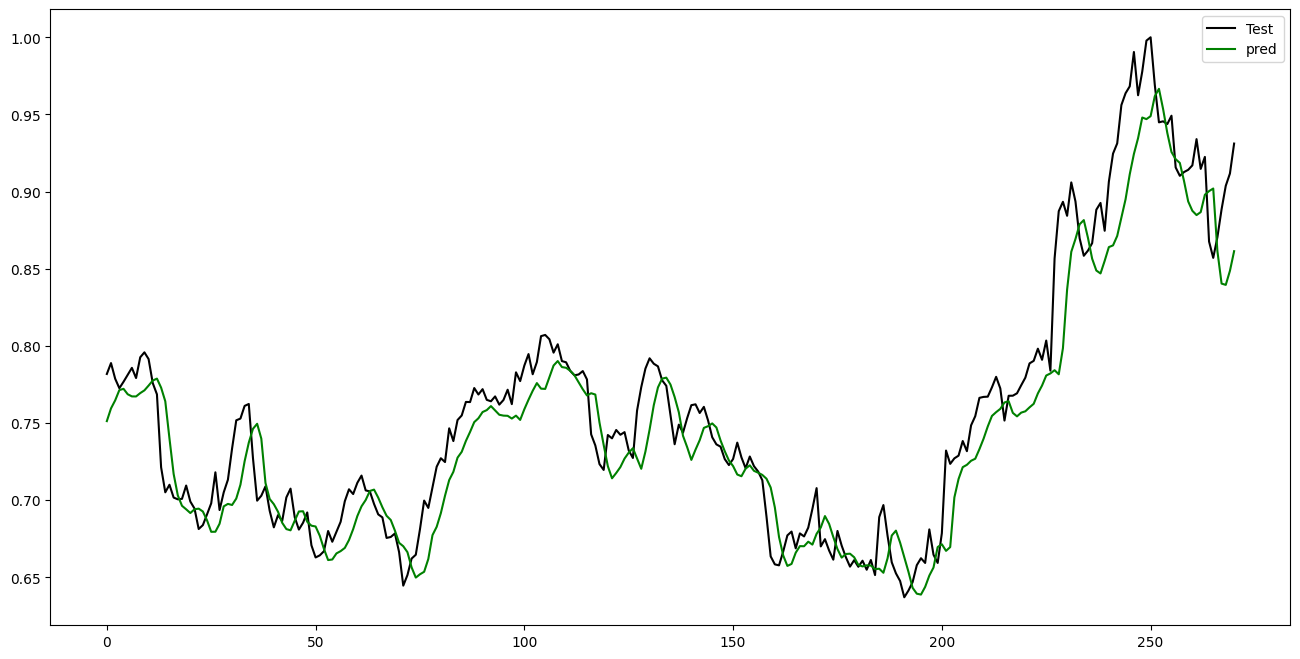

In [24]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()